# Data Exploration Notebook

The goal of this notebook is strictly to understand the data and to be able to easily feed it in our model during Training in the pipeline.

In [1]:
# import libraries
import sagemaker
import yaml
import boto3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import struct
from array import array
import random

In [4]:
SESS = sagemaker.Session()
DEFAULT_BUCKET = SESS.default_bucket()

with open("../env.yml", "r") as f:
    env = yaml.load(f, Loader=yaml.FullLoader)

PROJECT_ID = env["project_id"]
SOURCE_DIR = env["source_dir"]
ENTRY_POINT = env["entry_point"]
MODEL_ID = env["model_id"]
PYTHON_VERSION = env["python_version"]
FRAMEWORK_VERSION = env["framework_version"]
IMG_SIZE = env["img_size"]

DATA_LOCATION = f"s3://{DEFAULT_BUCKET}/{PROJECT_ID}/data"



## Analyze the data

## Import the data from S3

In [5]:
# downloading files from s3
print("Downloading data from s3...")
s3_client = boto3.client("s3")
s3_client.download_file(Bucket=DEFAULT_BUCKET, Key=f"{PROJECT_ID}/data/train/train-images-idx3-ubyte.gz", Filename="../data/train-images-idx3-ubyte.gz")
s3_client.download_file(Bucket=DEFAULT_BUCKET, Key=f"{PROJECT_ID}/data/train/train-labels-idx1-ubyte.gz", Filename="../data/train-labels-idx1-ubyte.gz")
s3_client.download_file(Bucket=DEFAULT_BUCKET, Key=f"{PROJECT_ID}/data/test/t10k-images-idx3-ubyte.gz", Filename="../data/t10k-images-idx3-ubyte.gz")
s3_client.download_file(Bucket=DEFAULT_BUCKET, Key=f"{PROJECT_ID}/data/test/t10k-labels-idx1-ubyte.gz", Filename="../data/t10k-labels-idx1-ubyte.gz")

In [6]:
%%sh
# unzip all files
gunzip ../data/*

## Load the data 

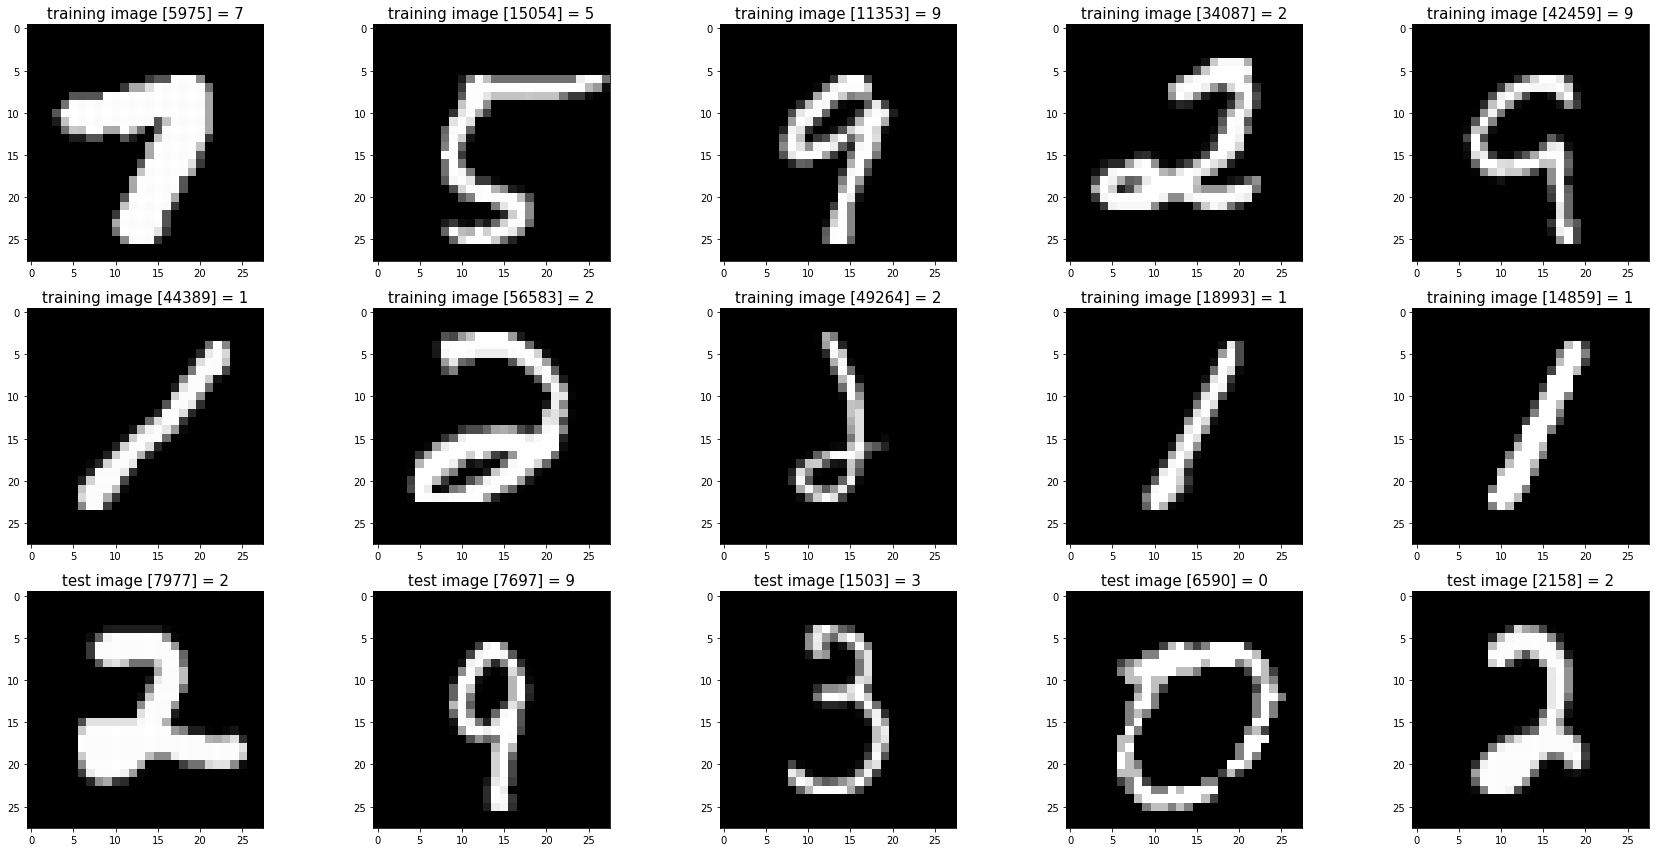

In [7]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(IMG_SIZE, IMG_SIZE)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)


#
# Set file paths based on added MNIST Datasets
#
input_path = '../data'
training_images_filepath = os.path.join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(input_path, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

### Training data

In [8]:
print("Number of training samples :", len(x_train))
print("Number of testing samples :", len(x_test))

Number of training samples : 60000
Number of testing samples : 10000


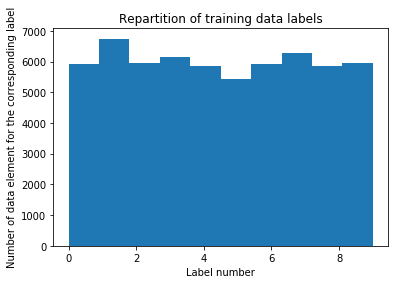

In [9]:
# repartition of label in data
label_values_train = np.array(y_train)
plt.hist(label_values_train)
plt.title("Repartition of training data labels")
plt.xlabel("Label number")
plt.ylabel("Number of data element for the corresponding label")
plt.show()

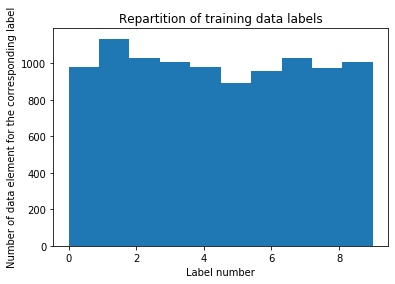

In [12]:
# repartition of label in data
label_values_test = np.array(y_test)
plt.hist(label_values_test)
plt.title("Repartition of training data labels")
plt.xlabel("Label number")
plt.ylabel("Number of data element for the corresponding label")
plt.show()

The repartition of labels is uniform which is fine.

In [28]:
print("Shape of the train data :")
print(np.expand_dims(np.array(x_train), -1).shape)
print(np.array(y_train).shape)

print("Shape of the test data :")
print(np.expand_dims(np.array(x_test), -1).shape)
print(np.array(y_test).shape)

Shape of the train data :
(60000, 28, 28, 1)
(60000,)
Shape of the test data :
(10000, 28, 28, 1)
(10000,)


## Cleaning

Do not forget to delete the data donwload in this notebook server.

In [11]:
%%sh
rm ../data/*